In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from numpy import linalg as LA
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.python.framework import ops
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
#x_train = np.expand_dims(x_train, axis=3)
#x_test = np.expand_dims(x_test, axis=3)
x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)



Instructions for updating:
non-resource variables are not supported in the long term
x_train shape: (60000, 784)
60000 train samples
10000 test samples


In [2]:
class SNVRGOptimizer(tf.train.Optimizer):
    def __init__(self, loss, K, learning_rate=1e-3):
        self.K = K
        self._learning_rate = learning_rate
        
        self._grads_and_vars = self._compute_gradients(loss)
        
        self._reference_gradient_ph = [[tf.placeholder(tf.float32, shape=v.get_shape()) for _, v in self._grads_and_vars]
                                       for _ in range(self.K+1)]
        
        self._update = self._compute_single_update
        
    def _compute_gradients(self, loss):
        opt = tf.train.GradientDescentOptimizer(learning_rate=1)
        grads_and_vars = opt.compute_gradients(loss)
        grads_and_vars = [(g, v) for g, v in grads_and_vars if not isinstance(g, ops.IndexedSlices)]
        
        return grads_and_vars
            
    def _compute_single_update(self, l):
        grads_and_vars = self._grads_and_vars
        
        update_ops = []
        for i, (_, v) in enumerate(grads_and_vars):
            g = self._reference_gradient_ph[l][i]
            
            update = - self._learning_rate * g
            update_ops.append(v.assign_add(update))
            
        return tf.group(*update_ops)
    
    def batch_update(self, sess, feed_dict, feed_dict_total, n, batch_size, loop_params, mini_batch_params, lr=None):
        if lr is not None:
            self._learning_rate = lr
        
        input_total_ph = list(feed_dict_total.keys())
        input_total_data = list(feed_dict_total.values())
        
        input_ph = list(feed_dict.keys())
        input_data = list(feed_dict.values())
        
        gs, vs = zip(*self._grads_and_vars)
        shift_gradients = []
        for l in range(K+1):
            gss = []
            for g in gs:
                gss.append(tf.identity(g))
                
            shift_gradients.append(gss)
        
        reference_gradients = [[np.zeros(v.get_shape().as_list()) for v in vs] for _ in range(self.K+1)]
        reference_gradients[0] = sess.run(gs, feed_dict=feed_dict)
        
        feed_dict.update(dict(zip(self._reference_gradient_ph[0], reference_gradients[0])))
        _ = sess.run(self._update(0), feed_dict=feed_dict)

        for t in range(1, np.prod(loop_params)):      
            gs, vs = zip(*self._grads_and_vars)
            
            r = find_index(t, loop_params)
            
            for l in range(r, K+1):
                samples = np.random.choice(n, size = mini_batch_params[l-1], replace=False)
                feed_dict_single = {input_total_ph[j]: input_total_data[j][samples] for j in range(len(input_total_data))}
                
                gss = []
                for g in gs:
                    gss.append(tf.identity(g))
                shift_gradients[l] = gss
                
                for i, g in enumerate(shift_gradients[l]):
                    reference_gradients[l][i] = sess.run(g - shift_gradients[l-1][i], feed_dict=feed_dict_single)
                
            for l in range(K+1):
                feed_dict_single.update(dict(zip(self._reference_gradient_ph[l], reference_gradients[l])))
                _ = sess.run(self._update(l), feed_dict=feed_dict_single)

class SVRGOptimizer(tf.train.Optimizer):
    def __init__(self, loss, learning_rate=1e-3):
        self._learning_rate = learning_rate

        self._grads_and_vars = self._compute_gradients(loss)
        
        self._variance_reduction_ph = [tf.placeholder(tf.float32, shape=v.get_shape()) 
                                           for _, v in self._grads_and_vars]
        self._bias_correction_ph = [tf.placeholder(tf.float32, shape=v.get_shape())
                                           for _, v in self._grads_and_vars]
    
        self._update = self._compute_single_update()
        
    def _compute_gradients(self, loss):
        opt = tf.train.GradientDescentOptimizer(learning_rate=1)
        grads_and_vars = opt.compute_gradients(loss)
        grads_and_vars = [(g, v) for g, v in grads_and_vars if not isinstance(g, ops.IndexedSlices)]
        
        return grads_and_vars
    
    def _compute_single_update(self):
        grads_and_vars = self._grads_and_vars
        
        update_ops = []
        for i, (g, v) in enumerate(grads_and_vars):
            g += self._bias_correction_ph[i] - self._variance_reduction_ph[i]
            
            update = - self._learning_rate * g
            update_ops.append(v.assign_add(update))
            
        return tf.group(*update_ops)
    
    def batch_update(self, sess, feed_dict, batch_size, inner_iter, lr=None):
        if lr is not None:
            self._learning_rate = lr
        
        feed_dict_single = []
        gs, _ = zip(*self._grads_and_vars)
        bias_correction = sess.run(gs, feed_dict=feed_dict)
        
        input_ph = list(feed_dict.keys())
        input_data = list(feed_dict.values())
        
        for i in range(inner_iter):
            sample = np.random.randint(batch_size)
            feed_dict_single.append({input_ph[j]: input_data[j][sample:sample+1] for j in range(len(input_data))})
            
        for i in range(inner_iter):
            single_grads_and_vars = sess.run(gs, feed_dict=feed_dict_single[i])
            
            _feed_dict = feed_dict_single[i]
            _feed_dict.update(dict(zip(self._bias_correction_ph, bias_correction)))
            _feed_dict.update(dict(zip(self._variance_reduction_ph, single_grads_and_vars)))
            
            _ = sess.run(self._update, feed_dict=_feed_dict)

In [3]:
def loss(y, pred):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=pred))
    return cross_entropy

# Image size in MNIST dataset is (28, 28), so the first convolutional layer is applied with SAME padding, to fit with the LeNet architecture
def CNN_LeNet(images):
    net = tf.reshape(images, shape=[-1, 28, 28, 1])
    net = Conv2D(filters=6, kernel_size=5, strides=(1, 1), activation='relu', padding='SAME')(net)
    net = MaxPool2D(strides=(2, 2))(net)
    net = Conv2D(filters=16, kernel_size=5, strides=(1, 1), activation='relu', padding='VALID')(net)
    net = MaxPool2D(strides=(2, 2))(net)
    net = Flatten()(net)
    net = Dense(120, activation='relu')(net)
    net = Dense(84, activation='relu')(net)
    net = Dense(10, activation=None)(net)
    
    return net

import random
def pack_batch(features, targets, dataset_size, batch_size):
    x_batch = []
    y_batch = []
    for i in range(batch_size):
        index = random.randint(0, dataset_size-1)
        x_batch.append(features[index])
        y_batch.append(targets[index])
    return np.array(x_batch), np.array(y_batch)

def evaluate(y, y_pred):
    preds = tf.argmax(y_pred, axis=1)
    y_true = tf.argmax(y, axis=1)
    err = 1. - tf.reduce_mean(tf.cast(tf.equal(y_true, preds), tf.float32))
    return err
# Define the function to find the mod index
def find_index(t, loop_params):
    """ finds r = min{j: 0=(m mod Prod(T_l)), 0<=j<=K}
    """
    K = len(loop_params)
    T = 1.0
    for j in range(K, 0, -1):
        T1 = T * loop_params[j-1]
        if t % T == 0 and t % T1 != 0:
            return j
        T = T1
    return 0


In [4]:
tf.reset_default_graph()

lr = 0.005
epochs = 50
BATCH_SIZE = 512

X = tf.placeholder(dtype='float32', shape=(None, x_train.shape[1]))
y = tf.placeholder(dtype='float32', shape=(None, y_train.shape[1]))

y_pred = CNN_LeNet(X)
cost = loss(y, y_pred)

opt = tf.train.GradientDescentOptimizer(learning_rate=lr)
optimizer = opt.minimize(cost)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    sgd_loss_history = []
    sgd_test_error_history = []
    sgd_nb_grads = []
    nb_grads = 0
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
#         batch = mnist.train.next_batch(batch_size)
    
        nBatches = int(x_train.shape[0]/BATCH_SIZE)
        for i in range(nBatches):   
            x_batch,y_batch = pack_batch(x_train, y_train, x_train.shape[0], BATCH_SIZE)
            feed_dict = {X: x_batch, y: y_batch}
            _, c = sess.run([optimizer, cost], feed_dict=feed_dict)
            nb_grads += BATCH_SIZE
        
        test_error = evaluate(y, y_pred)
        err = sess.run(test_error, feed_dict={X: x_test, y: y_test})
        
        sgd_loss_history.append(c)
        sgd_test_error_history.append(err)
        sgd_nb_grads.append(nb_grads)
        print("\tLoss: {} \tTest Error: {}".format(c, err))


Epoch 1/50
	Loss: 2.191722869873047 	Test Error: 0.6498000025749207
Epoch 2/50
	Loss: 1.7604517936706543 	Test Error: 0.37849998474121094
Epoch 3/50
	Loss: 0.8986113667488098 	Test Error: 0.20679998397827148
Epoch 4/50
	Loss: 0.4854273796081543 	Test Error: 0.14719998836517334
Epoch 5/50
	Loss: 0.4890482425689697 	Test Error: 0.12110000848770142
Epoch 6/50
	Loss: 0.35314249992370605 	Test Error: 0.10850000381469727
Epoch 7/50
	Loss: 0.4107893705368042 	Test Error: 0.09780001640319824
Epoch 8/50
	Loss: 0.2888531982898712 	Test Error: 0.08890002965927124
Epoch 9/50
	Loss: 0.30128738284111023 	Test Error: 0.0835999846458435
Epoch 10/50
	Loss: 0.3299127221107483 	Test Error: 0.07840001583099365
Epoch 11/50
	Loss: 0.27967166900634766 	Test Error: 0.07529997825622559
Epoch 12/50
	Loss: 0.33116617798805237 	Test Error: 0.07319998741149902
Epoch 13/50
	Loss: 0.23479345440864563 	Test Error: 0.06959998607635498
Epoch 14/50
	Loss: 0.24551177024841309 	Test Error: 0.0690000057220459
Epoch 15/50
	

In [6]:
tf.reset_default_graph()

lr = 0.005
momentum=0.9
epochs = 50
BATCH_SIZE = 512

X = tf.placeholder(dtype='float32', shape=(None, x_train.shape[1]))
y = tf.placeholder(dtype='float32', shape=(None, y_train.shape[1]))

y_pred = CNN_LeNet(X)
cost = loss(y, y_pred)

opt = tf.train.MomentumOptimizer(learning_rate=lr, momentum= momentum)
optimizer = opt.minimize(cost)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    sgdM_loss_history = []
    sgdM_test_error_history = []
    sgdM_nb_grads = []
    sgdM_grads = 0
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
#         batch = mnist.train.next_batch(batch_size)
    
        nBatches = int(x_train.shape[0]/BATCH_SIZE)
        for i in range(nBatches):   
            x_batch,y_batch = pack_batch(x_train, y_train, x_train.shape[0], BATCH_SIZE)
            feed_dict = {X: x_batch, y: y_batch}
            _, c = sess.run([optimizer, cost], feed_dict=feed_dict)
            nb_grads += BATCH_SIZE
        
        test_error = evaluate(y, y_pred)
        err = sess.run(test_error, feed_dict={X: x_test, y: y_test})
        
        sgdM_loss_history.append(c)
        sgdM_test_error_history.append(err)
        sgdM_nb_grads.append(nb_grads)
        print("\tLoss: {} \tTest Error: {}".format(c, err))


Epoch 1/50
	Loss: 0.29882556200027466 	Test Error: 0.10850000381469727
Epoch 2/50
	Loss: 0.21144898235797882 	Test Error: 0.06379997730255127
Epoch 3/50
	Loss: 0.17737098038196564 	Test Error: 0.0461999773979187
Epoch 4/50
	Loss: 0.11619478464126587 	Test Error: 0.034900009632110596
Epoch 5/50
	Loss: 0.1062203198671341 	Test Error: 0.03750002384185791
Epoch 6/50
	Loss: 0.05729369446635246 	Test Error: 0.0274999737739563
Epoch 7/50
	Loss: 0.10155761241912842 	Test Error: 0.030099987983703613
Epoch 8/50
	Loss: 0.09004724025726318 	Test Error: 0.025699973106384277
Epoch 9/50
	Loss: 0.047096412628889084 	Test Error: 0.022000014781951904
Epoch 10/50
	Loss: 0.07066981494426727 	Test Error: 0.020500004291534424
Epoch 11/50
	Loss: 0.054614387452602386 	Test Error: 0.020299971103668213
Epoch 12/50
	Loss: 0.06178929656744003 	Test Error: 0.01819998025894165
Epoch 13/50
	Loss: 0.042555518448352814 	Test Error: 0.019800007343292236
Epoch 14/50
	Loss: 0.06585225462913513 	Test Error: 0.018499970436

In [22]:
tf.reset_default_graph()

max_iter_inner = 64
lr = 0.005
epochs = 50
BATCH_SIZE = 512

X = tf.placeholder(dtype='float32', shape=(None, x_train.shape[1]))
y = tf.placeholder(dtype='float32', shape=(None, y_train.shape[1]))

y_pred = CNN_LeNet(X)
cost = loss(y, y_pred)

optimizer = SVRGOptimizer(cost, lr)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    svrg_loss_history = []
    svrg_test_error_history = []
    svrg_nb_grads = []
    nb_grads = 0
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        # learning rate decay every 50 epochs
#         if epoch % 20 == 0 and epoch != 0:
#             lr *= 0.9

        nBatches = int(x_train.shape[0]/BATCH_SIZE)
        for i in range(nBatches):   
            x_batch,y_batch = pack_batch(x_train, y_train, x_train.shape[0], BATCH_SIZE)
            feed_dict = {X: x_batch, y: y_batch}
            optimizer.batch_update(sess, feed_dict, BATCH_SIZE, max_iter_inner, lr)
            nb_grads += BATCH_SIZE + max_iter_inner
        
        c = sess.run(cost, feed_dict=feed_dict)
        
        test_error = evaluate(y, y_pred)
        err = sess.run(test_error, feed_dict={X: x_test, y: y_test})
        
        
        svrg_loss_history.append(c)
        svrg_test_error_history.append(err)
        svrg_nb_grads.append(nb_grads)
        print("\tLoss: {} \tTest Error: {}".format(c, err))

Epoch 1/50
	Loss: 0.09033997356891632 	Test Error: 0.04439997673034668
Epoch 2/50
	Loss: 0.05516035854816437 	Test Error: 0.027000010013580322
Epoch 3/50
	Loss: 0.06644649803638458 	Test Error: 0.02890002727508545
Epoch 4/50
	Loss: 0.019691212102770805 	Test Error: 0.018599987030029297
Epoch 5/50
	Loss: 0.029289547353982925 	Test Error: 0.01690000295639038
Epoch 6/50
	Loss: 0.02216227352619171 	Test Error: 0.014999985694885254
Epoch 7/50
	Loss: 0.014089393429458141 	Test Error: 0.01389998197555542
Epoch 8/50
	Loss: 0.01866927742958069 	Test Error: 0.013199985027313232
Epoch 9/50
	Loss: 0.013565290719270706 	Test Error: 0.011799991130828857
Epoch 10/50
	Loss: 0.00882001779973507 	Test Error: 0.012899994850158691
Epoch 11/50
	Loss: 0.006411159876734018 	Test Error: 0.01130002737045288
Epoch 12/50
	Loss: 0.002965183462947607 	Test Error: 0.013100028038024902
Epoch 13/50
	Loss: 0.005627748556435108 	Test Error: 0.012199997901916504
Epoch 14/50
	Loss: 0.03308435529470444 	Test Error: 0.0177

In [31]:
tf.reset_default_graph()

lr = 0.001
epochs = 50
batch_size = 512

X = tf.placeholder(dtype='float32', shape=(None, 784))
y = tf.placeholder(dtype='float32', shape=(None, 10))

y_pred = CNN_LeNet(X)
cost = loss(y, y_pred)

opt = tf.train.AdamOptimizer(learning_rate=lr)
optimizer = opt.minimize(cost)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    adam_loss_history = []
    adam_test_error_history = []
    adam_nb_grads = []
    nb_grads = 0
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        
        nBatches = int(x_train.shape[0]/BATCH_SIZE)
        for i in range(nBatches):
            feed_dict = {X: x_batch, y: y_batch}
            _, c = sess.run([optimizer, cost], feed_dict=feed_dict)
            nb_grads += batch_size
        
        test_error = evaluate(y, y_pred)
        err = sess.run(test_error, feed_dict={X: x_test, y: y_test})
        
        adam_loss_history.append(c)
        adam_test_error_history.append(err)
        adam_nb_grads.append(nb_grads)
        print("\tLoss: {} \tTest Error: {}".format(c, err))

Epoch 1/50
	Loss: 0.004772980697453022 	Test Error: 0.08840000629425049
Epoch 2/50
	Loss: 0.0007920599891804159 	Test Error: 0.08810001611709595
Epoch 3/50
	Loss: 0.0003171699936501682 	Test Error: 0.08630001544952393
Epoch 4/50
	Loss: 0.00017218300490640104 	Test Error: 0.08579999208450317
Epoch 5/50
	Loss: 0.00010811961692525074 	Test Error: 0.08590000867843628
Epoch 6/50
	Loss: 7.392776751657948e-05 	Test Error: 0.08539998531341553
Epoch 7/50
	Loss: 5.370828148443252e-05 	Test Error: 0.0853000283241272
Epoch 8/50
	Loss: 4.072841693414375e-05 	Test Error: 0.08550000190734863
Epoch 9/50
	Loss: 3.187861875630915e-05 	Test Error: 0.08590000867843628
Epoch 10/50
	Loss: 2.5584467948647216e-05 	Test Error: 0.08560001850128174
Epoch 11/50
	Loss: 2.093914372380823e-05 	Test Error: 0.08520001173019409
Epoch 12/50
	Loss: 1.7418784409528598e-05 	Test Error: 0.08539998531341553
Epoch 13/50
	Loss: 1.4680095773655921e-05 	Test Error: 0.08560001850128174
Epoch 14/50
	Loss: 1.2513594811025541e-05 	T

KeyboardInterrupt: 

In [ ]:
tf.reset_default_graph()


epochs = 100
BATCH_SIZE = x_train.shape[0]
loop_params = [4, 4]
batch_params = [8, 1]
lr = 0.01
K = len(loop_params)

X = tf.placeholder(dtype='float32', shape=(None, x_train.shape[1]))
y = tf.placeholder(dtype='float32', shape=(None, y_train.shape[1]))

y_pred = CNN_LeNet(X)
cost = loss(y, y_pred)

optimizer = SNVRGOptimizer(cost, K, lr)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    snvrg_loss_history = []
    snvrg_test_error_history = []
    snvrg_nb_grads = []
    nb_grads = 0
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        # learning rate decay every 30 epochs
        if epoch % 20 == 0 and epoch != 0:
            lr *= 0.9
#         batch = mnist.train.next_batch(batch_size)
        
        x_batch,y_batch = pack_batch(x_train, y_train, x_train.shape[0], batch_size)

        feed_dict = {X: x_batch, y: y_batch}
        feed_dict_total = {X: x_train, y: y_train}
        optimizer.batch_update(sess, feed_dict, feed_dict_total, x_train.shape[0], batch_size, loop_params, batch_params, lr)
        
        nb_grads += BATCH_SIZE
        
        for i, _ in enumerate(loop_params):
            nb_grads += batch_params[i] * np.prod(loop_params[:i+1])
        
        c = sess.run(cost, feed_dict=feed_dict)
        
        test_error = evaluate(y, y_pred)
        err = sess.run(test_error, feed_dict={X: x_test, y: y_test})
        
        snvrg_loss_history.append(c)
        snvrg_test_error_history.append(err)
        snvrg_nb_grads.append(nb_grads)
        print("\tLoss: {} \tTest Error: {}".format(c, err))


Epoch 1/100
	Loss: 2.291761875152588 	Test Error: 0.8855999708175659
Epoch 2/100
	Loss: 2.28511381149292 	Test Error: 0.8723999857902527
Epoch 3/100
	Loss: 2.268497943878174 	Test Error: 0.8467999696731567
Epoch 4/100
	Loss: 2.251711845397949 	Test Error: 0.8185999989509583
Epoch 5/100
	Loss: 2.237811803817749 	Test Error: 0.7401000261306763
Epoch 6/100
	Loss: 2.2063300609588623 	Test Error: 0.7017999887466431
Epoch 7/100
	Loss: 2.175267457962036 	Test Error: 0.6841000318527222
Epoch 8/100
	Loss: 2.1371002197265625 	Test Error: 0.6200000047683716
Epoch 9/100
	Loss: 2.063934564590454 	Test Error: 0.5812000036239624
Epoch 10/100
	Loss: 2.013160467147827 	Test Error: 0.5241000056266785
Epoch 11/100
	Loss: 1.8930619955062866 	Test Error: 0.4764000177383423
Epoch 12/100
	Loss: 1.7453889846801758 	Test Error: 0.4789000153541565
Epoch 13/100
	Loss: 1.8278934955596924 	Test Error: 0.5810999870300293
Epoch 14/100
	Loss: 3.3253750801086426 	Test Error: 0.7993999719619751
Epoch 15/100
	Loss: 2.24

No handles with labels found to put in legend.


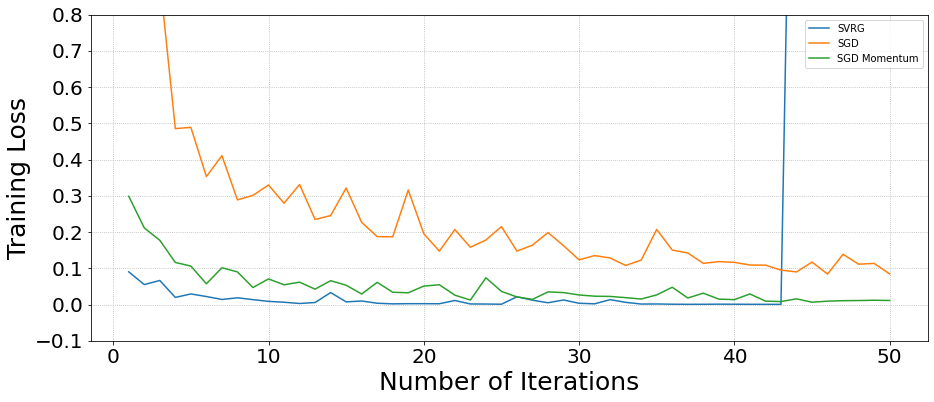

No handles with labels found to put in legend.


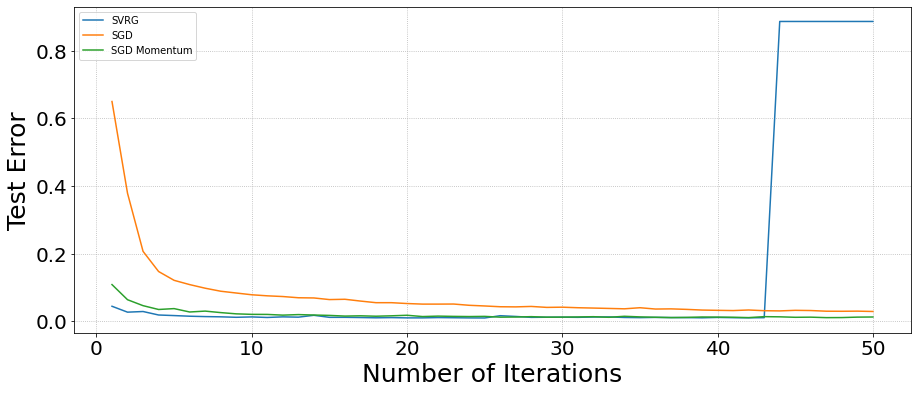

In [26]:
plt.figure(figsize=(15, 6))
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
x_ticks=np.arange(0,epochs+1,10)
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Training Loss', fontsize=25)
plt.plot(np.arange(1,epochs+1,1), svrg_loss_history, label="SVRG")
# plt.plot(np.arange(1,epochs+1,1), snvrg_loss_history,label = "SNVRG")
plt.plot(np.arange(1,epochs+1,1), sgd_loss_history,  label ="SGD")
plt.plot(np.arange(1,epochs+1,1), sgdM_loss_history,  label ="SGD Momentum")
axes = plt.gca()
axes.set_ylim([-.1, 0.8])
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
x_ticks=np.arange(0,epochs+1,10)
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Test Error', fontsize=25)
# plt.plot(np.arange(1,epochs+1,1), snvrg_test_error_history, label="SVRG")
plt.plot(np.arange(1,epochs+1,1), svrg_test_error_history, label="SVRG")
plt.plot(np.arange(1,epochs+1,1), sgd_test_error_history, label = "SGD")
plt.plot(np.arange(1,epochs+1,1), sgdM_test_error_history, label = "SGD Momentum")
plt.legend()
plt.show()

In [27]:
# import numpy
# np.savetxt("svrg_loss_MNSIT_lenet_b512_005.csv", svrg_loss_history, delimiter=",")
# np.savetxt("svrg_err_MNSIT_lenet_b512_005.csv", svrg_test_error_history, delimiter=",")

# np.savetxt("SGD_loss_MNSIT_lenet_b512_005.csv", sgd_loss_history, delimiter=",")
# np.savetxt("SGD_err_MNSIT_lenet_b512_005.csv", sgd_test_error_history, delimiter=",")


# np.savetxt("SGDM_loss_MNSIT_lenet_b512_005.csv", sgdM_loss_history, delimiter=",")
# np.savetxt("SGDM_err_MNSIT_lenet_b512_005.csv", sgdM_test_error_history, delimiter=",")


In [11]:
len(sgd_loss_history)

50

In [ ]:
Epoch 1/400
	Loss: 2.2974693775177 	Test Error: 0.8888000249862671
Epoch 2/400
	Loss: 2.2794289588928223 	Test Error: 0.8698999881744385
Epoch 3/400
	Loss: 2.2652807235717773 	Test Error: 0.8371999859809875
Epoch 4/400
	Loss: 2.263267993927002 	Test Error: 0.7793999910354614
Epoch 5/400
	Loss: 2.236816883087158 	Test Error: 0.7459999918937683
Epoch 6/400
	Loss: 2.2154452800750732 	Test Error: 0.739799976348877
Epoch 7/400
	Loss: 2.2082769870758057 	Test Error: 0.7181000113487244
Epoch 8/400
	Loss: 2.1509904861450195 	Test Error: 0.6541000008583069
Epoch 9/400
	Loss: 2.0951058864593506 	Test Error: 0.6796000003814697
Epoch 10/400
	Loss: 2.0562057495117188 	Test Error: 0.5284000039100647
Epoch 11/400
	Loss: 1.931072473526001 	Test Error: 0.616100013256073
Epoch 12/400
	Loss: 1.9638309478759766 	Test Error: 0.6543999910354614
Epoch 13/400
	Loss: 2.78375506401062 	Test Error: 0.8971999883651733
Epoch 14/400
	Loss: 2.2632625102996826 	Test Error: 0.7829999923706055
Epoch 15/400
	Loss: 2.2146618366241455 	Test Error: 0.7264000177383423
Epoch 16/400
	Loss: 2.16519832611084 	Test Error: 0.6805999875068665
Epoch 17/400
	Loss: 2.144831657409668 	Test Error: 0.6194000244140625
Epoch 18/400
	Loss: 2.0803661346435547 	Test Error: 0.5827000141143799
Epoch 19/400
	Loss: 1.983586311340332 	Test Error: 0.5746999979019165
Epoch 20/400
	Loss: 1.858149528503418 	Test Error: 0.5430999994277954
Epoch 21/400
	Loss: 1.6495838165283203 	Test Error: 0.5108000040054321
Epoch 22/400
	Loss: 1.5779430866241455 	Test Error: 0.4089999794960022
Epoch 23/400
	Loss: 1.488139271736145 	Test Error: 0.42330002784729004
Epoch 24/400
	Loss: 2.0987186431884766 	Test Error: 0.6003000140190125
Epoch 25/400
	Loss: 2.022920846939087 	Test Error: 0.7799000144004822
Epoch 26/400
	Loss: 1.8410029411315918 	Test Error: 0.5211000442504883
Epoch 27/400
	Loss: 1.5288430452346802 	Test Error: 0.40469998121261597
Epoch 28/400
	Loss: 1.2447736263275146 	Test Error: 0.35100001096725464
Epoch 29/400
	Loss: 1.0477855205535889 	Test Error: 0.2964000105857849
Epoch 30/400
	Loss: 1.30971097946167 	Test Error: 0.4398999810218811
Epoch 31/400
	Loss: 3.400454044342041 	Test Error: 0.6750999689102173
Epoch 32/400
	Loss: 2.1511147022247314 	Test Error: 0.6965000033378601
Epoch 33/400
	Loss: 2.0723040103912354 	Test Error: 0.5819000005722046
Epoch 34/400
	Loss: 1.9265536069869995 	Test Error: 0.515500009059906
Epoch 35/400
	Loss: 1.788590431213379 	Test Error: 0.47460001707077026
Epoch 36/400
	Loss: 1.6273157596588135 	Test Error: 0.420199990272522
Epoch 37/400
	Loss: 1.399641513824463 	Test Error: 0.4007999897003174
Epoch 38/400
	Loss: 1.141735315322876 	Test Error: 0.35519999265670776
Epoch 39/400
	Loss: 1.0256099700927734 	Test Error: 0.29589998722076416
Epoch 40/400
	Loss: 1.299290418624878 	Test Error: 0.48580002784729004
Epoch 41/400
	Loss: 2.1161069869995117 	Test Error: 0.5997999906539917
Epoch 42/400
	Loss: 1.4908688068389893 	Test Error: 0.42739999294281006
Epoch 43/400